In this notebook we generate parabolic curves according to the smiley-frowny toy model.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive

/content/gdrive


In [ ]:
nat_path = 'My Drive/Machine Learning/errors study/github/'

In [ ]:
# Import stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import time
from datetime import date
from sklearn.metrics import accuracy_score

# Distributions
from scipy.stats import johnsonsu, poisson, norm

from scipy.optimize import curve_fit

# Define Functions



*   Generate theoretical smiley-frowny curves
*   Add Gaussian noise
*   Visualize theoretical curves + measurements with error bars
*   Generate smiley-frowny curves: Poisson Version



## Gauss Version

In [ ]:
# Generating Data
def curves_SmileyFrowny(m, n):
  """
  Generate theoretical curves according to the smiley-frowny model.
  :param m: number of instances
  :type m: int
  :param n: number of features
  :type n: int
  :return: smiley-frowny curves with the corresponding labels
  :rtype: pandas.DataFrame(shape=(m, n + 1))

  Half of the sample is of type smiley and half is frowny.
  - 0 labels frowny
  - 1 labels smiley
  - returns the theoretical curves
  - generates m/2 smiley and m/2 frowny curves
  """

  m_half = int(m/2)  # get number of samples per label

  i = np.arange(1, n+1)

  i = np.tile(i, (m_half, 1))

  a1 = np.random.normal(1, 0.25, m_half)
  a0 = np.random.normal(-1, 0.25, m_half)
  b1 = np.random.normal(0, 1, m_half)
  b0 = np.random.normal(0, 1, m_half)
  c1 = np.random.normal(10, 3, m_half)
  c0 = np.random.normal(10, 3, m_half)

  x1 = (a1 * (i/n).T**2 + b1*(i/n).T + c1).T
  x0 = (a0 * ((i - n - 1)/n).T**2 + b0*((i - n - 1)/n).T + c0).T

  x1 = pd.DataFrame(x1)
  x0 = pd.DataFrame(x0)

  x1['type'] = 1
  x0['type'] = 0

  return pd.concat([x1, x0]).reset_index(drop=True)

In [ ]:
# Generating Errors
def gauss_noise(data, sigma0=0.5, delta_g=0.5, mean_g=0.6):
  """
  Add gaussian noise to the theoretical measurements from 'data'.
  :param data: theoretical curves
  :type data: pandas.DataFrame(shape=(m, n + 1))
  :return: dataset with measurement, errors and labels
  :rtype: pandas.DataFrame(shape=(m, 2n + 1))
  """

  # Save labels in the variable 'y' and save measurements in the variable 'Xbar'
  y = data['type']
  Xbar = data.drop(columns='type')

  m = len(Xbar)
  n = len(Xbar.T)
  
  g = np.random.uniform(mean_g - delta_g, mean_g + delta_g, (m, n))
  dX = pd.DataFrame(np.random.normal(0, g * sigma0))
  X = Xbar + dX

  # Save the error bars in a DataFrame
  err = pd.DataFrame(g) * sigma0

  # Name columns
  col = ['f{}'.format(_) for _ in range(1, n+1)]
  ecol = ['ef{}'.format(_) for _ in range(1, n+1)]

  X.columns = col
  err.columns = ecol

  # Build dataset: measurements, errors and class labels
  X = pd.concat([X, err], 1)
  X['type'] = y

  return X

In [ ]:
def plot_smileyfrowny_curves(curves, dataset, num_curves=2, rs=42):

  """
  Plot smiley-frowny theoretical curves and measurements for visualization
  purposes.
  :param curves: theoretical curves
  :type curves: pandas.DataFrame(shape=(m, n + 1))
  :param dataset: measurements with gaussian noise added
  :type dataset: pandas.DataFrame(shape=(m, 2n + 1))
  :param num_curves: number of curves per class to plot
  :type num_curves: int
  :param rs: random_state to select num_curves from the datasets
  :type rs: int
  """

  n = int(len(curves.T) - 1)
    
  fig, ax = plt.subplots(1, 1)

  smiley_curve = curves[curves['type'] == 1].sample(n=num_curves, random_state=rs)
  frowny_curve = curves[curves['type'] == 0].sample(n=num_curves, random_state=rs)

  smiley_data = dataset[dataset['type'] == 1].sample(n=num_curves, random_state=rs)
  frowny_data = dataset[dataset['type'] == 0].sample(n=num_curves, random_state=rs)


  for j in range(num_curves):

    ax.plot(np.arange(1, n+1, 1), smiley_curve.iloc[j, :-1],
            color='g', linewidth=0.8)
    
    ax.errorbar(np.arange(1, n+1, 1),
                y=smiley_data.iloc[j, :n], yerr=smiley_data.iloc[j, n:-1],
                color='g', marker='o', linewidth=0.8, ls='none', markersize=2)
    
    ax.plot(np.arange(1, n+1, 1), frowny_curve.iloc[j, :-1],
            color='b', linewidth=0.8)
    
    ax.errorbar(np.arange(1, n+1, 1),
                y=frowny_data.iloc[j, :n], yerr=frowny_data.iloc[j, n:-1],
                color='b', marker='o', linewidth=0.8, ls='none', markersize=2)


  ax.set_xlabel('$i$', fontsize=16)
  ax.set_ylabel('measurement', fontsize=16)

  ax.set_xticks([1, 5, 10, 15, 20])
  ax.tick_params(labelsize=14)

  plt.show()

## Poisson Version

In [ ]:
# Generating Data
def curves_SmileyFrowny_poisson(m, n):
  """
  Generate theoretical curves according to the smiley-frowny model
  - Poisson version: values closer to one, discard negative measurements.
  :param m: number of instances
  :type m: int
  :param n: number of features
  :type n: int
  :return: smiley-frowny curves with the corresponding labels
  :rtype: pandas.DataFrame(shape=(m(maybe lower), n + 1))
  """

  m_half = int(m/2)  # get number of samples per label

  i = np.arange(1, n+1)

  i = np.tile(i, (m_half, 1))

  a1 = np.random.normal(1, 0.25, m_half)
  a0 = np.random.normal(-1, 0.25, m_half)
  b1 = np.random.normal(0, 1, m_half)
  b0 = np.random.normal(0, 1, m_half)
  c1 = np.random.normal(3, 0.5, m_half)
  c0 = np.random.normal(4, 0.5, m_half)

  x1 = (a1 * (i/n).T**2 + b1*(i/n).T + c1).T
  x0 = (a0 * ((i - n - 1)/n).T**2 + b0*((i - n - 1)/n).T + c0).T

  x1[x1 < 0] = np.nan
  x0[x0 < 0] = np.nan

  x1 = pd.DataFrame(x1)
  x0 = pd.DataFrame(x0)

  x1 = x1.dropna()
  x0 = x0.dropna()

  x1['type'] = 1
  x0['type'] = 0

  return pd.concat([x1, x0]).reset_index(drop=True)

In [ ]:
# Generating Errors
def poisson_noise(data):
  """
  Poisson realization of the theoretical measurements from 'data'.
  :param data: theoretical curves
  :type data: pandas.DataFrame(shape=(m, n + 1))
  :return: dataset with measurement, errors and labels
  :rtype: pandas.DataFrame(shape=(m, 2n + 1))
  """

  # Save labels in the variable 'y' and save measurements in the variable 'Xbar'
  y = data['type']
  Xbar = data.drop(columns='type')

  n = len(Xbar.T)

  X = pd.DataFrame(np.random.poisson(Xbar))

  # The error is the square root of the measurement
  err = np.sqrt(X)

  # Name columns
  col = ['f{}'.format(_) for _ in range(1, n+1)]
  ecol = ['e_f{}'.format(_) for _ in range(1, n+1)]

  X.columns = col
  err.columns = ecol

  # Build dataset
  X = pd.concat([X, err], 1)
  X['type'] = y

  return X

# Generate smiley-frowny data: Gauss version

In [ ]:
# Choose number of instances
m = 100000

# Choose the number of points in the curves
n = 20

# Set noise parameters
delta_g = 0.5
sigma0 = 0.5

# Set file path to save the data
file_path = nat_path + 'datasets/'

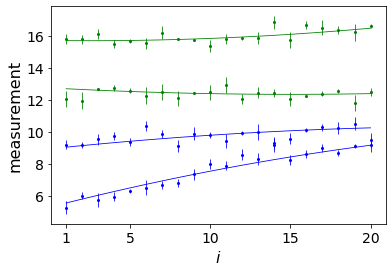

In [ ]:
curves = curves_SmileyFrowny(m, n)
dataset = gauss_noise(curves, sigma0, delta_g)

plot_smileyfrowny_curves(curves, dataset, rs=610)

In [ ]:
dataset = dataset.sample(frac=1)

In [ ]:
dataset.to_csv(nat_path + 'test.csv', index=False)

In [ ]:
# Save dataset
dataset.to_csv(file_path + \
               'test_m{}_n{}_sig{}_dg{}.csv'.format(int(m/1000), n,
                                                     int(sigma0*10),
                                                     int(delta_g*10)), index=False)

# Generate smiley-frowny data: Poisson version

In [ ]:
m = 100
n = 100

In [ ]:
curves = curves_SmileyFrowny_poisson(m, n)

In [ ]:
dataset = poisson_noise(curves)

In [ ]:
def plot_smileyfrowny_curves(curves, dataset, num_curves=2, rs=42):

  """
  Plot smiley-frowny theoretical curves and measurements for visualization
  purposes.
  :param curves: theoretical curves
  :type curves: pandas.DataFrame(shape=(m, n + 1))
  :param dataset: measurements with gaussian noise added
  :type dataset: pandas.DataFrame(shape=(m, 2n + 1))
  :param num_curves: number of curves per class to plot
  :type num_curves: int
  :param rs: random_state to select num_curves from the datasets
  :type rs: int
  """

  n = int(len(curves.T) - 1)
    
  fig, ax = plt.subplots(1, 1)

  smiley_curve = curves[curves['type'] == 1].sample(n=num_curves, random_state=rs)
  frowny_curve = curves[curves['type'] == 0].sample(n=num_curves, random_state=rs)

  smiley_data = dataset[dataset['type'] == 1].sample(n=num_curves, random_state=rs)
  frowny_data = dataset[dataset['type'] == 0].sample(n=num_curves, random_state=rs)


  for j in range(num_curves):

    ax.plot(np.arange(1, n+1, 1), smiley_curve.iloc[j, :-1],
            color='g', linewidth=0.8)
    
    ax.plot(np.arange(1, n+1, 1), smiley_data.iloc[j, :n],
            color='g', ls='None', marker='.')
    
    ax.plot(np.arange(1, n+1, 1), frowny_curve.iloc[j, :-1],
            color='b', linewidth=0.8)
    
    ax.plot(np.arange(1, n+1, 1), frowny_data.iloc[j, :n],
            color='b', ls='None', marker='.')


  ax.set_xlabel('$i$', fontsize=16)
  ax.set_ylabel('measurement', fontsize=16)

  ax.set_xticks(np.arange(1, n, 5))
  ax.tick_params(labelsize=14)

  plt.show()

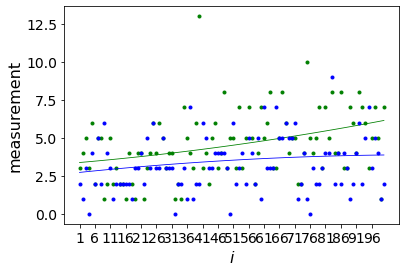

In [ ]:
plot_smileyfrowny_curves(curves, dataset, num_curves=1, rs=400)

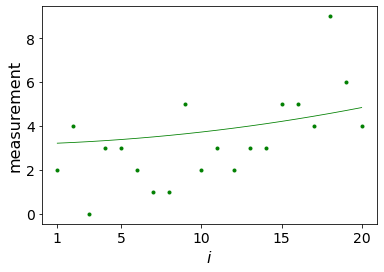

In [ ]:
plot_smileyfrowny_curves(curves, dataset, num_curves=1, rs=216)